In [24]:
import os
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import scipy.ndimage
from scipy.cluster.vq import kmeans, vq

In [3]:
def convert_from_unit(time, units):
    if units == "seconds since 2008-03-01 00:00:00":
        return datetime.utcfromtimestamp(time + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds())
    elif units == "seconds since 1970-01-01 00:00:00":
        return datetime.utcfromtimestamp(float(time))
    elif units == "nano":
        return datetime.utcfromtimestamp(time / 1000000000)
    else:
        raise ValueError("Apologies unable to read NetCDF with time unit: {}".format(units))

In [4]:
def get_closest_index(value, array):
    array = np.asarray(array)
    sorted_array = np.sort(array)
    if len(array) == 0:
        raise ValueError("Array must be longer than len(0) to find index of value")
    elif len(array) == 1:
        return 0
    if value > (2 * sorted_array[-1] - sorted_array[-2]):
        raise ValueError("Value {} greater than max available ({})".format(value, sorted_array[-1]))
    elif value < (2 * sorted_array[0] - sorted_array[-1]):
        raise ValueError("Value {} less than min available ({})".format(value, sorted_array[0]))
    return (np.abs(array - value)).argmin()

Upwelling

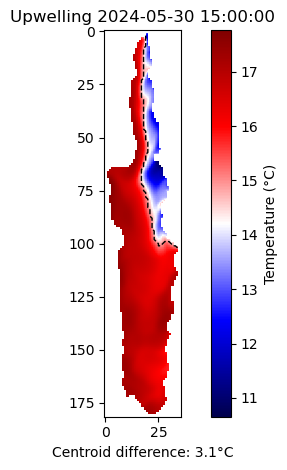

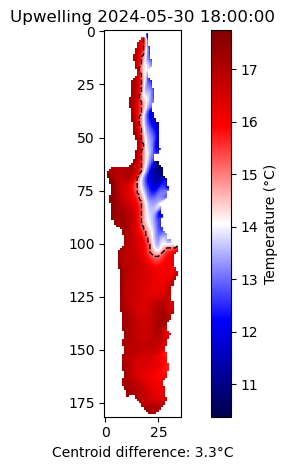

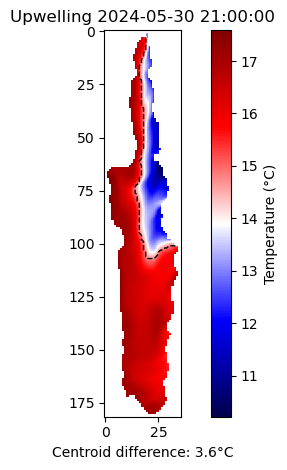

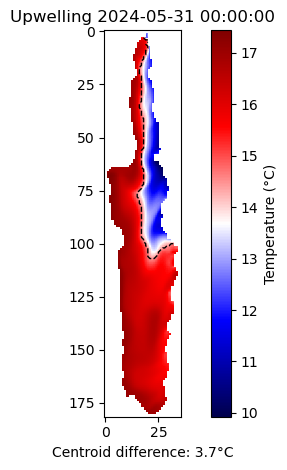

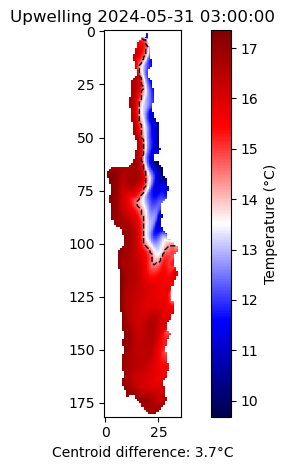

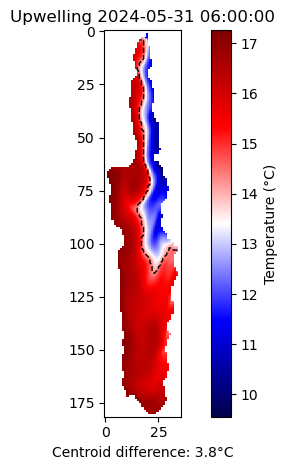

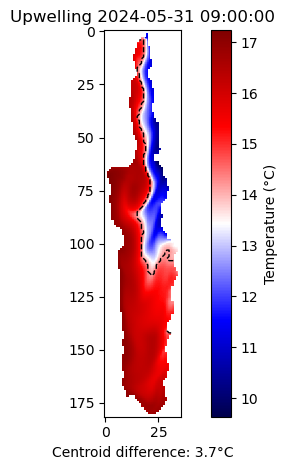

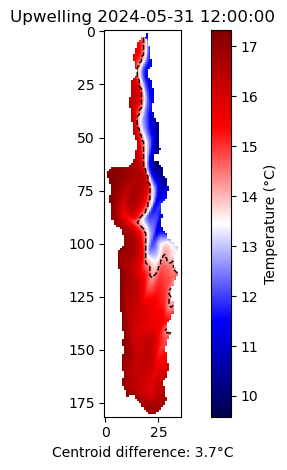

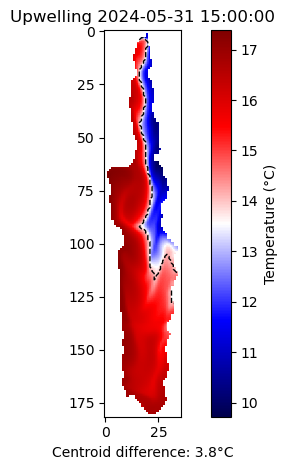

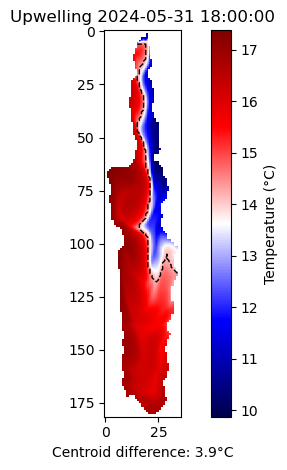

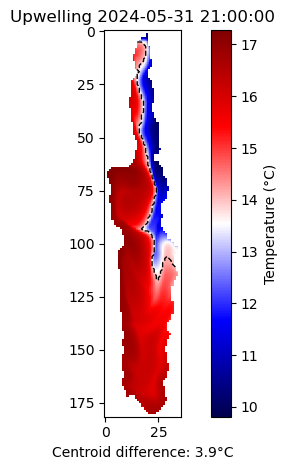

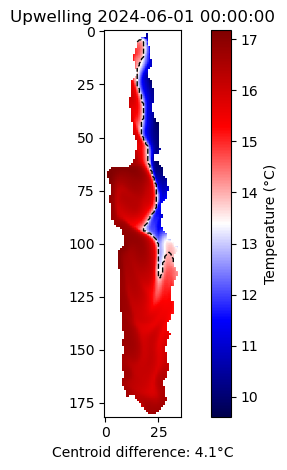

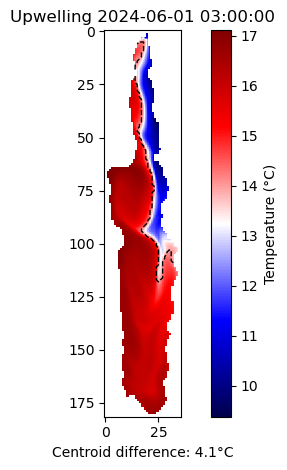

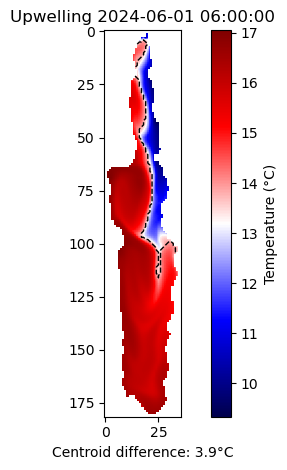

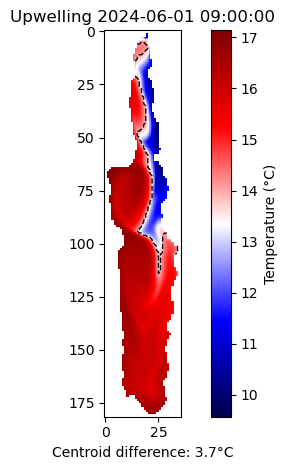

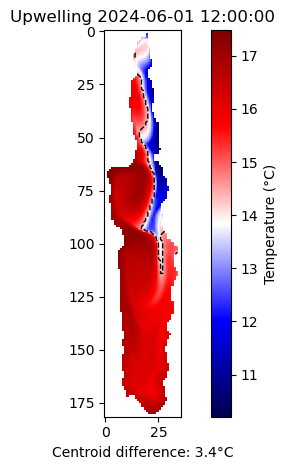

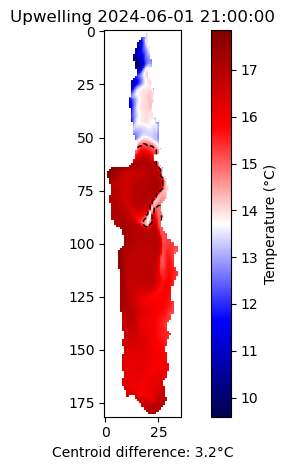

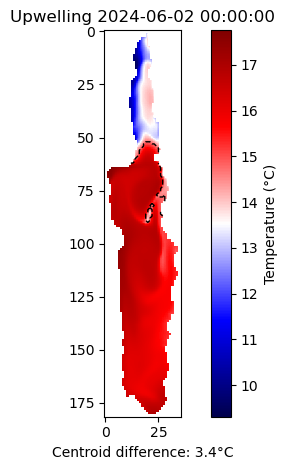

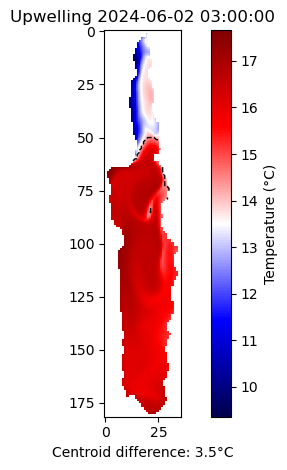

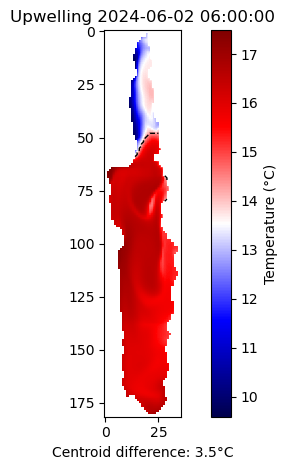

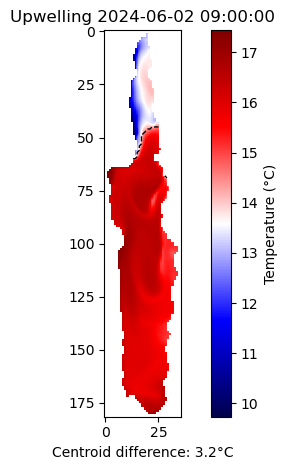

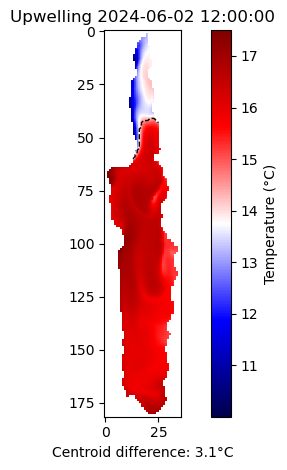

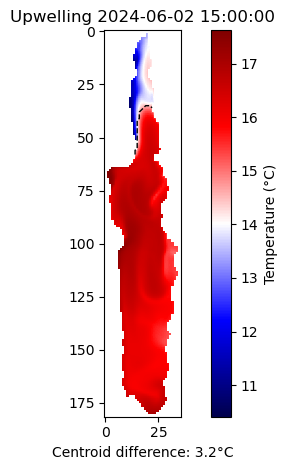

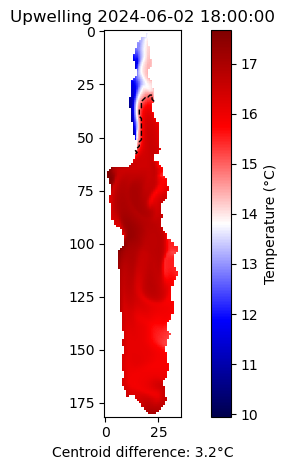

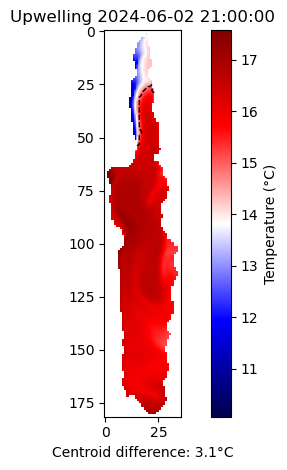

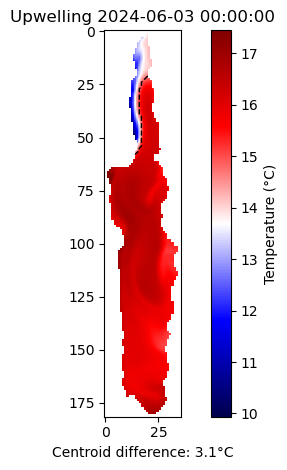

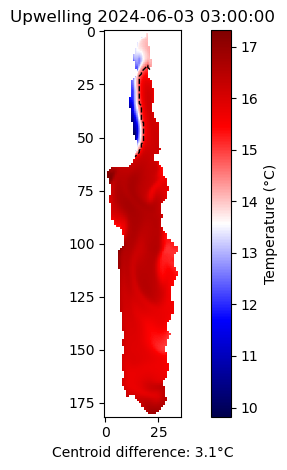

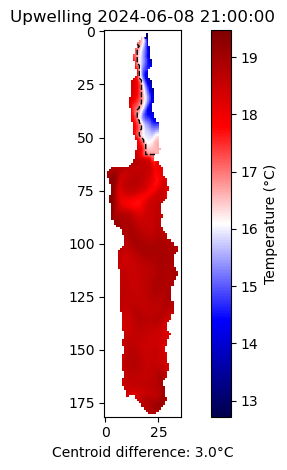

[{'start': '202405301500', 'peak': '202406010000', 'end': '202406011200', 'max_centroid': 4.127659797668457}, {'start': '202406012100', 'peak': '202406020300', 'end': '202406030300', 'max_centroid': 3.5133914947509766}, {'start': '202406082100', 'peak': '202406082100', 'end': '202406082100', 'max_centroid': 3.037795066833496}]


In [5]:
folder = "/home/runnalja/git/alplakes/simulations/runs/test"
parameters = { "centroid_difference": 3, "depth": 0.7 }

files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nc")]
files.sort()
events = []
event = False
for file in files:
    with netCDF4.Dataset(file) as nc:
        depth_index = get_closest_index(parameters["depth"], np.array(nc.variables["ZK_LYR"][:]) * -1)
        time = [convert_from_unit(t, nc.variables["time"].units) for t in nc.variables["time"][:]]
        for time_index in range(len(time)):
            values = np.array(nc.variables["R1"][time_index, 0, depth_index, :]).flatten()
            mask = values != -999
            data = values[mask]
            k = 2
            centroids, _ = kmeans(data, k)
            if len(centroids) == 2:
                diff = float(abs(centroids[1] - centroids[0]))
                if diff > parameters["centroid_difference"]:
                    if event == False:
                        event = {
                            "start": time[time_index].strftime('%Y%m%d%H%M'),
                            "peak": time[time_index].strftime('%Y%m%d%H%M'),
                            "end": time[time_index].strftime('%Y%m%d%H%M'),
                            "max_centroid": diff
                        }
                    else:
                        event["end"] = time[time_index].strftime('%Y%m%d%H%M')
                        if diff > event["max_centroid"]:
                            event["peak"] = time[time_index].strftime('%Y%m%d%H%M')
                            event["max_centroid"] = diff

                    # Plot results
                    cluster_labels, _ = vq(data, centroids)
                    plot_values = np.array(nc.variables["R1"][time_index, 0, depth_index, :])
                    plot_values[plot_values == -999] = np.nan
                    plt.imshow(plot_values, cmap='seismic')
                    plt.colorbar(label="Temperature (°C)")
                    plt.title("Upwelling {}".format(time[time_index]))
                    plt.xlabel("Centroid difference: {}°C".format(round(diff, 1)))
                    plt.tight_layout()
                    out = np.zeros(len(values))
                    out[:] = np.nan
                    out[mask] = cluster_labels
                    out = out.reshape(plot_values.shape)
                    plt.contour(list(range(out.shape[1])), list(range(out.shape[0])), out, levels=[0, 1], colors='k',
                                linewidths=1, linestyles='dashed')
                    #os.makedirs(os.path.join(folder, "upwelling"), exist_ok=True)
                    #plt.savefig(os.path.join(folder, "upwelling/upwelling_{}".format(time[time_index].strftime('%Y%m%d%H%M'))), bbox_inches='tight')
                    plt.show()
                    plt.close()
                elif event != False:
                    events.append(event)
                    event = False
            elif event != False:
                events.append(event)
                event = False
if event != False:
    events.append(event)
print(events)

Localised Currents

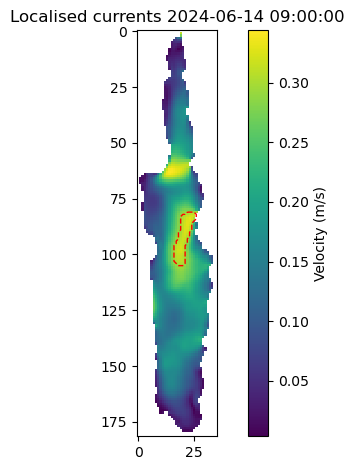

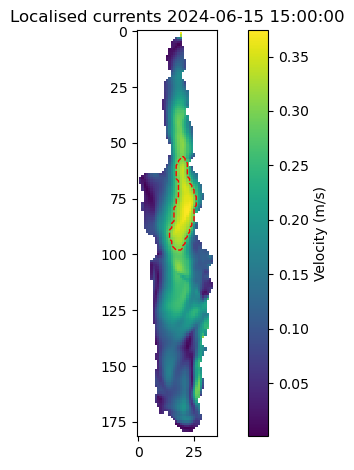

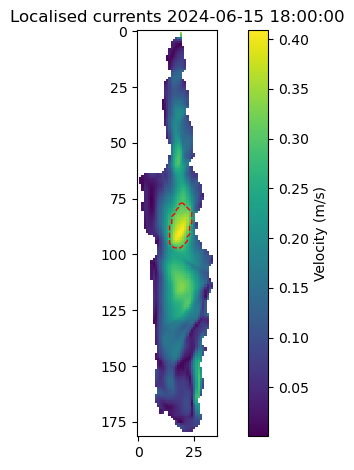

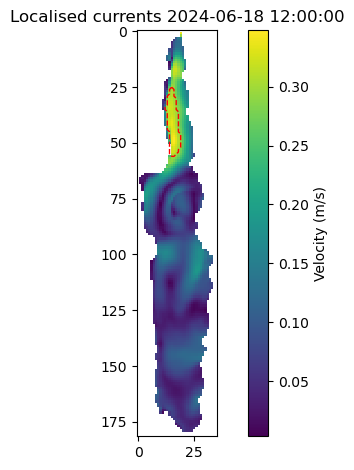

[{'start': '202406140900', 'end': '202406140900'}, {'start': '202406151500', 'end': '202406151800'}, {'start': '202406181200', 'end': '202406181200'}]


In [12]:
folder = "/home/runnalja/git/alplakes/simulations/runs/test2"
parameters = { "threshold": 0.3, "depth": 0.7, "minArea": 10, "maxArea": 50, "totalArea": 580 }

files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nc")]
files.sort()
events = []
event = False
structure = np.ones((3, 3))
for file in files:
    with netCDF4.Dataset(file) as nc:
        depth_index = get_closest_index(parameters["depth"], np.array(nc.variables["ZK_LYR"][:]) * -1)
        time = [convert_from_unit(t, nc.variables["time"].units) for t in nc.variables["time"][:]]
        area = np.count_nonzero(np.array(nc.variables["U1"][0, depth_index, :]) != -999)
        minCells = int(area * (parameters["minArea"] / parameters["totalArea"]))
        maxCells = int(area * (parameters["maxArea"] / parameters["totalArea"]))
        for time_index in range(len(time)):
            u = np.array(nc.variables["U1"][time_index, depth_index, :])
            v = np.array(nc.variables["V1"][time_index, depth_index, :])
            u[u == -999] = np.nan
            v[v == -999] = np.nan
            raw_values = (u**2 + v**2)**0.5
            values = raw_values.copy()
            values[np.isnan(values)] = -999
            values[values < parameters["threshold"]] = -999
            labeled_array, num_features = scipy.ndimage.label(values != -999, structure=structure)
            cluster_sizes = np.bincount(labeled_array.ravel())[1:]
            if len([c for c in cluster_sizes if c >= minCells and c <= maxCells]) > 0:
                if event == False:
                    event = {
                        "start": time[time_index].strftime('%Y%m%d%H%M'),
                        "end": time[time_index].strftime('%Y%m%d%H%M')
                    }
                else:
                    event["end"] = time[time_index].strftime('%Y%m%d%H%M')
                            
                data = labeled_array.copy()
                for i, c in enumerate(cluster_sizes):
                    if c >= minCells and c <= maxCells:
                        data[data == i+1] = 1
                    else:
                        data[data == i+1] = 0
                plt.imshow(raw_values, cmap='viridis', interpolation='nearest')
                plt.colorbar(label="Velocity (m/s)")
                plt.title("Localised currents {}".format(time[time_index]))
                plt.tight_layout()
                plt.contour(list(range(data.shape[1])), list(range(data.shape[0])), data, levels=[0, 1], colors='r',
                                linewidths=1, linestyles='dashed')
                #os.makedirs(os.path.join(folder, "upwelling"), exist_ok=True)
                #plt.savefig(os.path.join(folder, "upwelling/upwelling_{}".format(time[time_index].strftime('%Y%m%d%H%M'))), bbox_inches='tight')
                plt.show()
                plt.close()
            elif event != False:
                    events.append(event)
                    event = False
if event != False:
    events.append(event)
print(events)